<a href="https://colab.research.google.com/github/hyomee2/scooter-parking-detector/blob/main/pipeline/final_yolo_mobilenet_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 1. 초기 설정

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import torch
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from ultralytics import YOLO

# 모델 경로 설정
yolo_model_path = '/content/gdrive/MyDrive/result/yolov8n_finetune3/weights/best.pt'
model_stage1_path = '/content/gdrive/MyDrive/mobilenet/best_stage1_mobilenetv2.h5'
model_stage2_path = '/content/gdrive/MyDrive/mobilenet/best_stage2_mobilenetv2_focused_improper.h5'
test_data_root_dir = '/content/gdrive/MyDrive/dataset/cnn/test'

# mobilenet 입력 이미지 크기
model_input_size = (224, 224)

# 이전에 mobilenet에서 검증 데이터로 찾은 최적의 임계값 (mobilenet 코드 참고)
BEST_THRESHOLD = 0.01

# 최종 3개 클래스 이름 (출력 시 사용)
# 이 순서가 최종 매핑 (0:improper, 1:noise, 2:proper)과 일치해야 한다.
final_class_names = ['improper', 'noise', 'proper']

# 클래스 이름과 인덱스 매핑 (실제값 비교를 위해)
# 이 매핑은 'final_class_names' 순서와 일치해야 한다.
class_to_idx = {'improper': 0, 'noise': 1, 'proper': 2}

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## 2. 모델 불러오기

In [ ]:
# YOLO 모델 불러오기
print("YOLO 모델 불러오는 중 (YOLOv8)...")
try:
    yolo_model = YOLO(yolo_model_path)
    print("YOLO 모델 로드 완료")
except Exception as e:
    print(f"YOLO 모델 로드 중 오류 발생: {e}")
    exit()

# resnet 불러오기
print("\n mobilenet 모델 불러오는 중")
try:
    model_stage1 = load_model(model_stage1_path)
    model_stage2 = load_model(model_stage2_path)
    print("mobilenet 모델 로드 완료.")
except Exception as e:
    print(f"2단계 분류 모델 로드 중 오류 발생: {e}")
    exit()

YOLO 모델 불러오는 중 (YOLOv8)...
YOLO 모델 로드 완료

 mobilenet 모델 불러오는 중


mobilenet 모델 로드 완료.


## 3. 이미지 전처리 및 분류 수행

In [ ]:
print(f"\n'{test_data_root_dir}'에서 이미지 탐지 및 분류 수행 중...")

all_ground_truths = []
all_predictions = []
all_logits = []  # <-- AUC 계산을 위한 클래스 확률 저장용

image_paths_with_labels = []
for root, dirs, files in os.walk(test_data_root_dir):
    current_label_name = os.path.basename(root)
    if current_label_name in class_to_idx:
        ground_truth_idx = class_to_idx[current_label_name]
        for fname in files:
            if fname.lower().endswith(('.jpg')):
                full_path = os.path.join(root, fname)
                image_paths_with_labels.append((full_path, ground_truth_idx, current_label_name))

if not image_paths_with_labels:
    print(f"경고: '{test_data_root_dir}' 폴더 및 하위 폴더에 처리할 이미지가 없습니다.")
else:
    for img_path, ground_truth_idx, ground_truth_name in image_paths_with_labels:
        img_original = cv2.imread(img_path)
        if img_original is None:
            print(f"경고: 이미지를 읽을 수 없습니다 - {img_path}")
            continue

        print(f"\n--- 원본 이미지 처리 중: {os.path.basename(img_path)} (실제값: {ground_truth_name}) ---")

        results = yolo_model(img_original, verbose=False)

        detected_bboxes = []
        for r in results:
            boxes = r.boxes.xyxy.cpu().numpy()
            for i, bbox in enumerate(boxes):
                x1, y1, x2, y2 = map(int, bbox[:4])
                if x2 > x1 and y2 > y1:
                    bbox_area = (x2 - x1) * (y2 - y1)
                    detected_bboxes.append((x1, y1, x2, y2, bbox_area))

        if not detected_bboxes:
            print(f"정보: 탐지 실패 - '{os.path.basename(img_path)}'")
            predicted_class_index = class_to_idx['noise']
            final_predicted_name = final_class_names[predicted_class_index]
            print(f"-> 예측값: {final_predicted_name}")
            all_ground_truths.append(ground_truth_idx)
            all_predictions.append(predicted_class_index)
            # 확률 벡터: noise = 1.0, 나머지 = 0
            logits_vector = [0.0] * len(final_class_names)
            logits_vector[class_to_idx['noise']] = 1.0
            all_logits.append(logits_vector)
            continue

        largest_bbox_info = sorted(detected_bboxes, key=lambda x: x[4], reverse=True)[0]
        x1, y1, x2, y2, _ = largest_bbox_info
        cropped_bgr = img_original[y1:y2, x1:x2]
        cropped_rgb = cv2.cvtColor(cropped_bgr, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(cropped_rgb, model_input_size)
        img_array = image.img_to_array(img_resized)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        stage1_pred_prob = model_stage1.predict(img_array, verbose=0).flatten()[0]
        stage1_binary_pred = (stage1_pred_prob > BEST_THRESHOLD).astype(int)

        noise_prob, improper_prob, proper_prob = 0.0, 0.0, 0.0
        predicted_class_index = class_to_idx['noise']

        if stage1_binary_pred == 1:
            stage2_pred_probs = model_stage2.predict(img_array, verbose=0).flatten()
            improper_prob = stage2_pred_probs[0]
            proper_prob = stage2_pred_probs[1]
            if improper_prob > proper_prob:
                predicted_class_index = class_to_idx['improper']
            else:
                predicted_class_index = class_to_idx['proper']
        else:
            noise_prob = 1.0
            predicted_class_index = class_to_idx['noise']

        # 확률 벡터 생성 및 저장
        logits_vector = [0.0] * len(final_class_names)
        logits_vector[class_to_idx['improper']] = improper_prob
        logits_vector[class_to_idx['noise']] = noise_prob
        logits_vector[class_to_idx['proper']] = proper_prob
        all_logits.append(logits_vector)

        final_predicted_name = final_class_names[predicted_class_index]
        all_ground_truths.append(ground_truth_idx)
        all_predictions.append(predicted_class_index)

        print(f"-> 예측값: {final_predicted_name} (Stage1 Kickboard 확률: {stage1_pred_prob:.2f})\n")

print("\n--- 모든 이미지 처리 완료 ---")


'/content/gdrive/MyDrive/dataset/cnn/test'에서 이미지 탐지 및 분류 수행 중...

--- 원본 이미지 처리 중: D009.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.99)


--- 원본 이미지 처리 중: hm95.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.98)


--- 원본 이미지 처리 중: hm33.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.99)


--- 원본 이미지 처리 중: 271.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.95)


--- 원본 이미지 처리 중: B013.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.99)


--- 원본 이미지 처리 중: hm49.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.73)


--- 원본 이미지 처리 중: hm148.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.02)


--- 원본 이미지 처리 중: hm22.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.19)


--- 원본 이미지 처리 중: 225.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.77)


--- 원본 이미지 처리 중: hm29.jpg (실제값: improper) ---
-> 예측값: improper (Stage1 Kickboard 확률: 0.45)


--- 

## 4. 시각화


총 처리된 이미지 수: 111
전체 정답률 (Accuracy): 93.69%

혼동 행렬:
[[27  0  5]
 [ 0 15  0]
 [ 2  0 62]]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54844 (\N{HANGUL SYLLABLE HON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47148 (\N{HANGUL SYLLABLE RYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


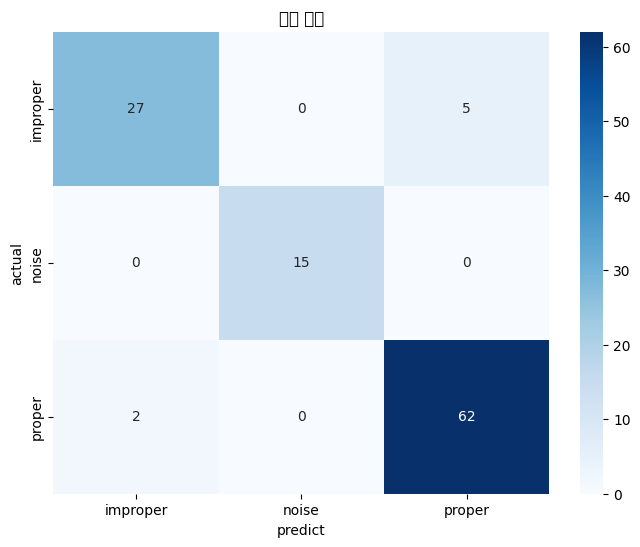


분류 리포트:
              precision    recall  f1-score   support

    improper       0.93      0.84      0.89        32
       noise       1.00      1.00      1.00        15
      proper       0.93      0.97      0.95        64

    accuracy                           0.94       111
   macro avg       0.95      0.94      0.94       111
weighted avg       0.94      0.94      0.94       111


📈 AUC Score (macro, ovr): 0.9903


In [ ]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 정답률 및 혼동 행렬 계산 및 출력
if len(all_ground_truths) > 0:
    # 전체 정답률
    accuracy = accuracy_score(all_ground_truths, all_predictions) * 100
    print(f"\n총 처리된 이미지 수: {len(all_ground_truths)}")
    print(f"전체 정답률 (Accuracy): {accuracy:.2f}%")

    # 혼동 행렬 계산
    cm = confusion_matrix(all_ground_truths, all_predictions)
    print("\n혼동 행렬:")
    print(cm)

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=final_class_names, yticklabels=final_class_names)
    plt.xlabel('predict')
    plt.ylabel('actual')
    plt.title('혼동 행렬')
    plt.show()

    # 분류 보고서
    print("\n분류 리포트:")
    print(classification_report(all_ground_truths, all_predictions, target_names=final_class_names))

    # ✅ AUC 계산
    from sklearn.metrics import roc_auc_score
    from sklearn.preprocessing import label_binarize
    import numpy as np

    # 정답을 one-hot 벡터로 변환
    y_true_bin = label_binarize(all_ground_truths, classes=list(range(len(final_class_names))))
    y_probs = np.array(all_logits)

    auc = roc_auc_score(y_true_bin, y_probs, average='macro', multi_class='ovr')
    print(f"\n✅ AUC Score (macro, ovr): {auc:.4f}")
else:
    print("\n처리된 이미지가 없어 정답률 및 혼동 행렬을 계산할 수 없습니다.")
